# Programming Exercise 8: Anomaly Detection and Recommender Systems

# Introduction
In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics. 

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import math
from scipy.optimize import fmin_cg, minimize

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 1 Anomaly detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \cdots, x^{(m)}\}$. You suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset. 


You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions. You will be using the script for this part of the exercise.

The first part of the script will visualize the dataset as shown in Figure 1

Visualizing example dataset for outlier detection.




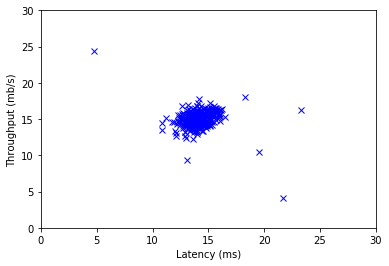

In [2]:
# ================== Part 1: Load Example Dataset  ===================
#  We start this exercise by using a small dataset that is easy to
#  visualize.
#
#  Our example case consists of 2 network server statistics across
#  several machines: the latency and throughput of each machine.
#  This exercise will help us find possibly faulty (or very fast) machines.
#

print('Visualizing example dataset for outlier detection.\n\n')

#  The following command loads the dataset. You should now have the
#  variables X, Xval, yval in your environment
mat = scipy.io.loadmat('ex8data1.mat')
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']

#  Visualize the example dataset
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

## 1.1 Gaussian distribution
To perform anomaly detection, you will first need to fit a model to the data's distribution.

Given a training set $\{x^{(1)}, \cdots, x^{(m)}\}$ (where $x^{(i)} \in \Bbb{R}^n$), you want to estimate the Gaussian distribution for each of the features $x_i$. For each feature i = 1 ... n, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the i-th dimension $\{x^{(1)}_i, \cdots, x^{(m)}_i \}$ (the i-th dimension of each example).

The Gaussian distribution is given by

$$p(x;\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

where $\mu$ is the mean and $\sigma^2$ controls the variance.

# 1.2 Estimating parameters for a Gaussian

You can estimate the parameters, $(\mu_i, \sigma^2_i )$, of the i-th feature by using the
following equations. To estimate the mean, you will use:
$$
\mu_i = \frac{1}{m}\sum^{m}_{j=1}x^{(j)}_i,
$$
and for the variance you will use:
$$
\sigma^2_i = \frac{1}{m}\sum^{m}_{j=1}(x_i^{(j)}-\mu_i)^2
$$

Your task is to complete the code in estimateGaussian.m. This function takes as input the data matrix X and should output an n-dimension vector mu that holds the mean of all the n features and another n-dimension vector sigma2 that holds the variances of all the features. You can implement this using a for-loop over every feature and every training example (though a vectorized implementation might be more effcient; feel free to use a vectorized implementation if you prefer). Note that in Python, the var function will (by default) use $\frac{1}{m}$, instead of  $\frac{1}{m-1}$, when computing $\sigma^2_i$.

Once you have completed the code in estimateGaussian.m, the next part of the script will visualize the contours of the fitted Gaussian distribution. You should get a plot similar to Figure 2. From your plot, you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

In [3]:
def estimateGaussian(X):
#ESTIMATEGAUSSIAN This function estimates the parameters of a 
#Gaussian distribution using the data in X
#   [mu sigma2] = estimateGaussian(X), 
#   The input X is the dataset with each n-dimensional data point in one row
#   The output is an n-dimensional vector mu, the mean of the data set
#   and the variances sigma^2, an n x 1 vector
# 
    # Useful variables
    m, n = X.shape

    # You should return these values correctly
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))

    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)

    return mu, sigma2

In [4]:
def visualizeFit(X, mu, sigma2):
#VISUALIZEFIT Visualize the dataset and its estimated distribution.
#   VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
#   probability density function of the Gaussian distribution. Each example
#   has a location (x1, x2) that depends on its feature values.
#
    x = np.linspace(0, 35, num=71, endpoint=True)
    X1, X2 = np.meshgrid(x, x)
    Z = multivariateGaussian(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))), mu, sigma2)
    Z = np.reshape(Z, X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx')
    # Do not plot if there are infinities
    if (np.sum(np.isinf(Z)) == 0):
        CS = plt.contour(X1, X2, Z, 10.0**np.arange(-20, 0, 3))
        #plt.clabel(CS, inline=1, fontsize=10)

In [5]:
def multivariateGaussian(X, mu, Sigma2):
#MULTIVARIATEGAUSSIAN Computes the probability density function of the
#multivariate gaussian distribution.
#    p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
#    density function of the examples X under the multivariate gaussian 
#    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
#    treated as the covariance matrix. If Sigma2 is a vector, it is treated
#    as the \sigma^2 values of the variances in each dimension (a diagonal
#    covariance matrix)
#

    k = mu.shape[0]

    Sigma2 = np.matrix(Sigma2)
    
    if (Sigma2.shape[1] == 1 or Sigma2.shape[0] == 1):
        Sigma2 = np.diag(Sigma2.A1)

    X = X - mu
          
    p = (2 * math.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5) * \
            np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(Sigma2)) * X, axis=1))
        
    return p

In [6]:
def selectThreshold(yval, pval):
#SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
#outliers
#   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
#   threshold to use for selecting outliers based on the results from a
#   validation set (pval) and the ground truth (yval).
#

    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    stepsize = (np.max(pval) - np.min(pval)) / 1000
    yval = yval.flatten()
    
    for epsilon in np.arange(np.min(pval), np.max(pval), stepsize):
        predictions = (pval < epsilon)
        tp = np.sum(np.logical_and(predictions, yval))
        fp = np.sum(np.logical_and(predictions, np.logical_not(yval)))
        fn = np.sum(np.logical_and(np.logical_not(predictions), yval))

        prec = tp/(tp+fp)
        rec = tp/(tp+fn)

        F1 = 2*prec*rec/(prec+rec)

        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

Visualizing Gaussian fit.




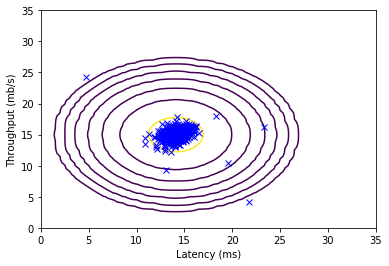

In [7]:
# ================== Part 2: Estimate the dataset statistics ===================
#  For this exercise, we assume a Gaussian distribution for the dataset.
#
#  We first estimate the parameters of our assumed Gaussian distribution, 
#  then compute the probabilities for each of the points and then visualize 
#  both the overall distribution and where each of the points falls in 
#  terms of that distribution.
#
print('Visualizing Gaussian fit.\n\n')

#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')


### 1.3 Selecting the threshold, $\epsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the $F_1$ score on a cross validation set.

You should now complete the code in selectThreshold.m. For this, we will use a cross validation set $ \{(x^{(1)}_{cv}, y^{(1)}_{cv}), \cdots, (x^{(m_{cv})}_{cv}, y^{(m_{cv})}_{cv})\}$, where the label y = 1 corresponds to an anomalous example, and y = 0 corresponds to a normal example. For each cross validation example, we will compute $p(x^{(i)}_{cv}), \cdots, p(x^{(m_{cv})}_{cv})$ is passed to selectThreshold in the vector pval. The corresponding labels $y^{(1)}_{cv}, \cdots, y^{(m_{cv})}_{cv}$ is passed to the same function in the vector yval.

The function selectThreshold should return two values; the first is the selected threshold $\epsilon$. If an example x has a low probability $p(x) < \epsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you're doing on finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly. 

The $F_1$ score is computed using precision (prec) and recall (rec):
$$
F_1 = \frac{2\cdot prec \cdot rec}{prec+rec},
$$
You compute precision and recall by:
$$
prec = \frac{tp}{tp+fp} \\
rec = \frac{tp}{tp+fn}
$$

where
* tp is the number of true positives: the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly.
* fp is the number of false positives: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.
* fn is the number of false negatives: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the provided code selectThreshold, there is already a loop that will try many different values of $\epsilon$ and select the best $\epsilon$ based on the $F_1$ score. 

You should now complete the code in selectThreshold. You can implement the computation of the $F_1$ score using a for-loop over all the cross validation examples (to compute the values tp, fp, fn). You should see a value for epsilon of about 8.99e-05.

Once you have completed the code in selectThreshold, the next step in the script will run your anomaly detection code and circle the anomalies in the plot (Figure 3).

Best epsilon found using cross-validation: 8.990853e-05

Best F1 on Cross Validation Set:  0.875000

   (you should see a value epsilon of about 8.99e-05)

   (you should see a Best F1 value of  0.875000)




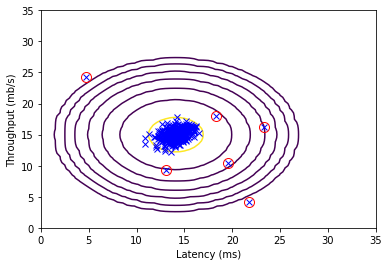

In [8]:
# ================== Part 3: Find Outliers ===================
#  Now you will find a good epsilon threshold using a cross-validation set
#  probabilities given the estimated Gaussian distribution
# 

pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %e\n' % epsilon)
print('Best F1 on Cross Validation Set:  %f\n' % F1)
print('   (you should see a value epsilon of about 8.99e-05)\n')
print('   (you should see a Best F1 value of  0.875000)\n\n')

#  Find the outliers in the training set and plot the
outliers = p < epsilon

#  Draw a red circle around those outliers
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, fillstyle='none')

## 1.4 High dimensional dataset

The last part of the script will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

The script will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma^2_i$), evaluate the probabilities for both the training data X from which you estimated the Gaussian parameters, and do so for the the cross-validation set Xval. Finally, it will use selectThreshold to find the best threshold $\epsilon$. You should see a value epsilon of about 1.38e-18, and 117 anomalies found.

In [9]:
# ================== Part 4: Multidimensional Outliers ===================
#  We will now use the code from the previous part and apply it to a 
#  harder problem in which more features describe each datapoint and only 
#  some features indicate whether a point is an outlier.
#

#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
mat = scipy.io.loadmat('ex8data2.mat')
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']

#  Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %e\n' % epsilon)
print('Best F1 on Cross Validation Set:  %f\n' % F1)
print('   (you should see a value epsilon of about 1.38e-18)\n')
print('   (you should see a Best F1 value of 0.615385)\n')
print('# Outliers found: %d\n\n' % np.sum(p < epsilon))


Best epsilon found using cross-validation: 1.377229e-18

Best F1 on Cross Validation Set:  0.615385

   (you should see a value epsilon of about 1.38e-18)

   (you should see a Best F1 value of 0.615385)

# Outliers found: 117




# 2 Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. For this part of the exercise, you will be working with the script ex8_cofi.m.

In the next parts of this exercise, you will implement the function cofiCostFunc that computes the collaborative fitlering objective function and gradient. After implementing the cost function and gradient, you will use fmincg to learn the parameters for collaborative filtering.

## 2.1 Movie ratings dataset
The first part of the script will load the dataset ex8_movies.mat, providing the variables Y and R in your Python environment. 

The matrix Y (a $num_movies \times num_users$ matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix R is an binary-valued indicator matrix, where $R(i, j)$ = 1 if user j gave a rating to movie i, and $R(i, j)$ = 0 otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j)$ = 0. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix Y, the script will compute the average movie rating for the first movie (Toy Story) and output the average rating to the screen. 

Throughout this part of the exercise, you will also be working with the matrices, X and Theta:
    
$$ X = \begin{bmatrix}
           - (x^{(1)})^T - \\
           - (x^{(2)})^T - \\
           \vdots \\
           - (x^{(m)})^T - \\
         \end{bmatrix}, 
   Theta = \begin{bmatrix}
           - (\theta^{(1)})^T - \\
           - (\theta^{(2)})^T - \\
           \vdots \\
           - (\theta^{(m)})^T - \\
         \end{bmatrix}$$

The i-th row of X corresponds to the feature vector $x^{(i)}$ for the i-th movie, and the j-th row of Theta corresponds to one parameter vector $\theta^{(j)}$, for the j-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors. For the purposes of this exercise, you will use n = 100, and therefore, $x^{(i)} \in \Bbb{R}^100$ and $\theta^{(j)} \in \Bbb{R}^100$

Correspondingly, X is a $n_m \times 100$ matrix and Theta is a $n_u \times 100$ matrix.

Loading movie ratings dataset.


Average rating for movie 1 (Toy Story): 2.583245 / 5




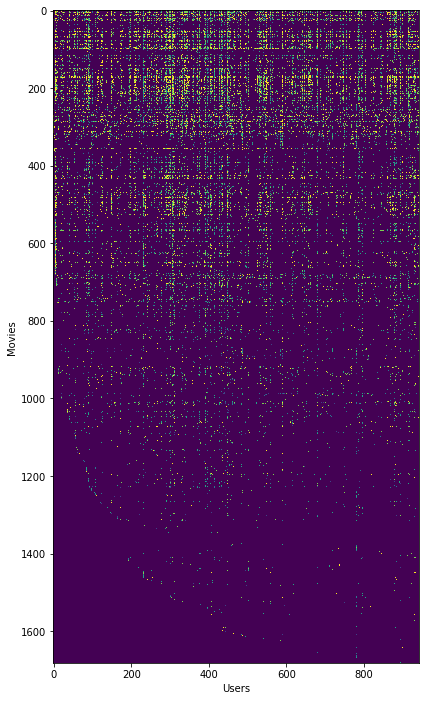

In [10]:
# =============== Part 1: Loading movie ratings dataset ================
#  You will start by loading the movie ratings dataset to understand the
#  structure of the data.
#  
print('Loading movie ratings dataset.\n\n')

#  Load data
mat = scipy.io.loadmat ('ex8_movies.mat')
R = mat['R']
Y = mat['Y']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5\n\n' % np.mean(Y[1, R[1, :]]))

#  We can "visualize" the ratings matrix by plotting it with imagesc
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
plt.ylabel('Movies');
plt.xlabel('Users');

## 2.2 Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \cdots, x^{(n_m)}$ and $\theta(1), \cdots, \theta^{(n_u)}$, where the model predicts the rating for movie i by user j as $y^{(i,j)} = (\theta^{(j)})^Tx^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \cdots, x^{(n_m)}, \theta^{(1)}, \cdots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in cofiCostFunc to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are X and Theta. In order to use an off-the-shelf minimizer such as fmincg, the cost function has been set up to unroll the parameters into a single vector params. You had previously used the same vector unrolling method in the neural networks programming exercise.

### 2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by 

$$
J(x^{(1)}, \cdots, x^{(n_m)}, \theta^{(1)}, \cdots, \theta^{(n_u)} = \frac{1}{2}\sum\limits_{(i,j):r(i,j)=1} ((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2.
$$
You should now modify cofiCostFunc to return this cost in the variable J. Note that you should be accumulating the cost for user j and movie i only if R(i; j) = 1.

After you have completed the function, the script will run your cost function. You should expect to see an output of 22.22.

In [11]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_t):
#COFICOSTFUNC Collaborative filtering cost function
#   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
#   num_features, lambda) returns the cost and gradient for the
#   collaborative filtering problem.
#
    # Unfold the U and W matrices from params
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((lambda_t / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((lambda_t / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (lambda_t * X)
    Theta_grad = (error.T * X) + (lambda_t * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.vstack((X_grad.reshape(-1, 1),  Theta_grad.reshape(-1, 1)))
    
    return J, grad

In [12]:
# ============ Part 2: Collaborative Filtering Cost Function ===========
#  You will now implement the cost function for collaborative filtering.
#  To help you debug your cost function, we have included set of weights
#  that we trained on that. Specifically, you should complete the code in 
#  cofiCostFunc.m to return J.

#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
mat = scipy.io.loadmat ('ex8_movieParams.mat')
Theta = mat['Theta']
X = mat['X']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

#  Evaluate cost function
J, _ = cofiCostFunc(np.vstack((X.reshape(-1, 1),  Theta.reshape(-1, 1))), Y, R, num_users, num_movies, num_features, 0);
           
print('Cost at loaded parameters: %f  \n(this value should be about 22.22)\n' % J);

Cost at loaded parameters: 22.224604  
(this value should be about 22.22)



### 2.2.2 Collaborative filtering gradient
Now, you should implement the gradient (without regularization). Specifically, you should complete the code in cofiCostFunc to return the variables X grad and Theta grad. Note that X grad should be a matrix of the same size as X and similarly, Theta grad is a matrix of the same size as Theta. The gradients of the cost function is given by:

$$\frac{\partial J}{\partial x_k^{(i)} } = \sum_{j:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})\theta_k^{(j)}$$

$$\frac{\partial J}{\partial \theta_k^{(j)} } = \sum_{i:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)}$$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. After you have completed the code to compute the gradients, the script will run a gradient check (checkCostFunction) to numerically check the implementation of your gradients. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

In [13]:
def computeNumericalGradient(J, theta):
#COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
#and gives us a numerical estimate of the gradient.
#   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
#   gradient of the function J around theta. Calling y = J(theta) should
#   return the function value at theta.

# Notes: The following code implements numerical gradient checking, and 
#        returns the numerical gradient.It sets numgrad(i) to (a numerical 
#        approximation of) the partial derivative of J with respect to the 
#        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
#        be the (approximately) the partial derivative of J with respect 
#        to theta(i).)
#                
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    for p in range(0, np.size(theta)):
        # Set perturbation vector
        perturb[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    return numgrad

In [14]:
def checkCostFunction(lambda_t = 0):
#CHECKCOSTFUNCTION Creates a collaborative filering problem 
#to check your cost function and gradients
#   CHECKCOSTFUNCTION(lambda) Creates a collaborative filering problem 
#   to check your cost function and gradients, it will output the 
#   analytical gradients produced by your code and the numerical gradients 
#   (computed using computeNumericalGradient). These two gradient 
#   computations should result in very similar values.

    # Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.matmul(X_t, Theta_t.T)
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]

    cost_func = lambda t: cofiCostFunc(t, Y, R, num_users, num_movies, num_features, lambda_t)
    numgrad = computeNumericalGradient(cost_func, np.vstack((X.reshape(-1, 1),  Theta.reshape(-1, 1))))

    cost, grad = cofiCostFunc(np.vstack((X.reshape(-1, 1),  Theta.reshape(-1, 1))), \
                                        Y, R, num_users, num_movies, num_features, lambda_t)


    for i, (numgrad_ , grad_) in enumerate(zip(numgrad, grad)):
        print("%f\t%f" % (numgrad_, grad_))
    
    print('The above two columns you get should be very similar.\n (Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your cost function implementation is correct, then \n the relative difference will be small (less than 1e-9). \n \nRelative Difference: %g\n' % diff)


In [15]:
# ============== Part 3: Collaborative Filtering Gradient ==============
#  Once your cost function matches up with ours, you should now implement 
#  the collaborative filtering gradient function. Specifically, you should 
#  complete the code in cofiCostFunc.m to return the grad argument.
#  
print('\nChecking Gradients (without regularization) ... \n');

#  Check gradients by running checkNNGradients
checkCostFunction()


Checking Gradients (without regularization) ... 

-2.759472	-2.759472
-0.040628	-0.040628
3.588062	3.588062
0.205081	0.205081
0.139349	0.139349
-0.001090	-0.001090
-1.011914	-1.011914
0.008558	0.008558
1.225896	1.225896
0.435791	0.435791
0.156341	0.156341
0.135326	0.135326
0.557460	0.557460
-3.008167	-3.008167
-1.787039	-1.787039
1.807099	1.807099
-2.323227	-2.323227
-4.971089	-4.971089
-0.216585	-0.216585
0.639980	0.639980
0.563009	0.563009
0.000000	0.000000
0.000000	0.000000
0.000000	0.000000
-3.121128	-3.121128
2.876491	2.876491
7.357249	7.357249
The above two columns you get should be very similar.
 (Left-Your Numerical Gradient, Right-Analytical Gradient)


If your cost function implementation is correct, then 
 the relative difference will be small (less than 1e-9). 
 
Relative Difference: 8.0852e-13



### 2.2.3 Regularized cost function
The cost function for collaborative ltering with regularization is given by

$$
J(x^{(1)}, \cdots, x^{(n_m)}, \theta^{(1)}, \cdots, \theta^{(n_u)} = \frac{1}{2}\sum\limits_{(i,j):r(i,j)=1} ((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2 + (\frac{\lambda}{2}\sum^{n_u}_{j=1}\sum^{n}_{k=1}(\theta^{(j)}_k)^2) + (\frac{\lambda}{2}\sum^{n_m}_{i=1}\sum^{n}_{k=1}(x^{(i)}_k)^2).
$$

You should now add regularization to your original computations of the cost function, J. After you are done, the script will run your regularized cost function, and you should expect to see a cost of about 31.34.

In [16]:
# ========= Part 4: Collaborative Filtering Cost Regularization ========
#  Now, you should implement regularization for the cost function for 
#  collaborative filtering. You can implement it by adding the cost of
#  regularization to the original cost computation.
#  

#  Evaluate cost function
J, _ = cofiCostFunc(np.vstack((X.reshape(-1, 1), Theta.reshape(-1, 1))), Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda = 1.5): %f  \n(this value should be about 31.34)\n' % J)


Cost at loaded parameters (lambda = 1.5): 31.344056  
(this value should be about 31.34)



### 2.2.4 Regularized gradient
Now that you have implemented the regularized cost function, you should proceed to implement regularization for the gradient. You should add to your implementation in cofiCostFunc to return the regularized gradient by adding the contributions from the regularization terms. Note that the gradients for the regularized cost function is given by:

$$\frac{\partial J}{\partial x_k^{(i)} } = \sum_{j:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})\theta_k^{(j)} + \lambda x^{(i)}_k$$

$$\frac{\partial J}{\partial \theta_k^{(j)} } = \sum_{i:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)} + \lambda \theta^{(j)}_k$$

This means that you just need to add $\lambda x(i)$ to the X_grad(i,:) variable described earlier, and add $\lambda\theta^{(j)}$ to the Theta_grad(j,:) variable described earlier.


After you have completed the code to compute the gradients, the script will run another gradient check (checkCostFunction) to numerically check the implementation of your gradients.

In [17]:
# ======= Part 5: Collaborative Filtering Gradient Regularization ======
#  Once your cost matches up with ours, you should proceed to implement 
#  regularization for the gradient. 
#

#  
print('\nChecking Gradients (with regularization) ... \n')

#  Check gradients by running checkNNGradients
checkCostFunction(1.5)


Checking Gradients (with regularization) ... 

4.325111	4.325111
-4.224242	-4.224242
4.433862	4.433862
2.223754	2.223754
-0.692858	-0.692858
-0.109859	-0.109859
-2.641769	-2.641769
-0.004504	-0.004504
-2.263935	-2.263935
3.115600	3.115600
-9.374859	-9.374859
-4.769422	-4.769422
0.795454	0.795454
-3.241866	-3.241866
0.772048	0.772048
-0.680943	-0.680943
6.760548	6.760548
-1.072318	-1.072318
3.360463	3.360463
-2.264430	-2.264430
5.410672	5.410672
0.577622	0.577622
6.630554	6.630554
-2.992024	-2.992024
0.667373	0.667373
9.378724	9.378724
1.871413	1.871413
The above two columns you get should be very similar.
 (Left-Your Numerical Gradient, Right-Analytical Gradient)


If your cost function implementation is correct, then 
 the relative difference will be small (less than 1e-9). 
 
Relative Difference: 2.46477e-12



### 2.3 Learning movie recommendations

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the next part of the script, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file movie_idx.txt.

In [18]:
def loadMovieList():
#GETMOVIELIST reads the fixed movie list in movie.txt and returns a
#cell array of the words
#   movieList = GETMOVIELIST() reads the fixed movie list in movie.txt 
#   and returns a cell array of the words in movieList.

    # Read the fixed movieulary list
    f = open('movie_ids.txt', errors='ignore')

    # Store all movies in cell array movie{}
    n = 1682;  # Total number of movies 
    movieList = {}
    
    for line in f:
        tokens = line.split(' ')
        tokens[-1] = tokens[-1][:-1]
        movieList[int(tokens[0]) - 1] = ' '.join(tokens[1:])

    return movieList 

In [19]:
# ============== Part 6: Entering ratings for a new user ===============
#  Before we will train the collaborative filtering model, we will first
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow you to put in your own ratings for the
#  movies in our dataset!
#
movieList = loadMovieList()

#  Initialize my ratings
my_ratings = np.zeros((1682, 1))

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

print('\n\nNew user ratings:\n');
for i in range(0, len(my_ratings)):
    if my_ratings[i] > 0: 
        print('Rated %d for %s\n' % (my_ratings[i], movieList[i]))



New user ratings:

Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forrest Gump (1994)

Rated 2 for Silence of the Lambs, The (1991)

Rated 4 for Alien (1979)

Rated 5 for Die Hard 2 (1990)

Rated 5 for Sphere (1998)



In [20]:
def normalizeRatings(Y, R):
#NORMALIZERATINGS Preprocess data by subtracting mean rating for every 
#movie (every row)
#   [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
#   has a rating of 0 on average, and returns the mean rating in Ymean.
#
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(0, m):
        idx = np.where(R[i, :] == 1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean

In [21]:
# ================== Part 7: Learning Movie Ratings ====================
#  Now, you will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users
#

print('\nTraining collaborative filtering...\n');

#  Load data
mat = scipy.io.loadmat ('ex8_movies.mat')
R = mat['R']
Y = mat['Y']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.hstack((my_ratings, Y));
R = np.hstack(((my_ratings != 0), R))

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.vstack((X.reshape(-1, 1), Theta.reshape(-1, 1)))

# Set Regularization
lambda_t = 10

cost_func = lambda t: cofiCostFunc(t.reshape(-1,1), Ynorm, R, num_users, num_movies, num_features, lambda_t)[0]
grad_func = lambda t: cofiCostFunc(t.reshape(-1,1), Ynorm, R, num_users, num_movies, num_features, lambda_t)[1].A1

    
theta = fmin_cg(cost_func, initial_parameters.T, fprime=grad_func, maxiter=100, disp=True)
#theta = minimize(fun=cost_func, x0=initial_parameters, 
#                method='CG', jac=grad_func, options={'maxiter': 100, 'disp':True})

# Unfold the returned theta back into U and W
X = np.reshape(theta[0:num_movies*num_features], (num_movies, num_features))
Theta = np.reshape(theta[num_movies*num_features:], (num_users, num_features))

print('Recommender system learning completed.\n')


Training collaborative filtering...

         Current function value: 38959.878554
         Iterations: 100
         Function evaluations: 160
         Gradient evaluations: 160
Recommender system learning completed.



### 2.3.1 Recommendations

After the additional ratings have been added to the dataset, the script will proceed to train the collaborative filtering model. This will learn the parameters X and Theta. To predict the rating of movie i for user j, you need to compute $(\theta^{(j)})^T x^{(i)}$. The next part of the script computes the ratings for all the movies and users and displays the movies that it recommends (Figure 4), according to ratings that were entered earlier in the script. Note that you might obtain a different set of the predictions due to dierent random initializations.

In [22]:
# ================== Part 8: Recommendation for you ====================
#  After training the model, you can now make recommendations by computing
#  the predictions matrix.
#

p = np.matmul(X, Theta.T)
my_predictions = p[:,0].reshape(-1, 1) + Ymean

movieList = loadMovieList()

ix = np.argsort(my_predictions, axis=0)[::-1]
print("Top 10 movie predictions:")
for i in range(10):
    j = int(ix[i])
    print('Predicted rating of %f for movie %s.' % (my_predictions[j], movieList[j]))

print('\n\nOriginal ratings provided:\n');
for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print('Rated %d for %s\n' % (my_ratings[i], movieList[i]))

Top 10 movie predictions:
Predicted rating of 5.000007 for movie Prefontaine (1997).
Predicted rating of 5.000002 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.000000 for movie Santa with Muscles (1996).
Predicted rating of 5.000000 for movie Star Kid (1997).
Predicted rating of 5.000000 for movie Saint of Fort Washington, The (1993).
Predicted rating of 5.000000 for movie They Made Me a Criminal (1939).
Predicted rating of 5.000000 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 5.000000 for movie Someone Else's America (1995).
Predicted rating of 4.999998 for movie Great Day in Harlem, A (1994).
Predicted rating of 4.999977 for movie Aiqing wansui (1994).


Original ratings provided:

Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forre